In [0]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, datasets
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

from google.colab.patches import cv2_imshow

In [0]:
# 하이퍼파라미터
epochs = 300
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

Using Device: cuda


In [0]:
# Fashion MNIST 데이터셋

# mean, std 각각 0.5로 정규화하는 transform 정의
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# 위의 transform을 따르도록 Dataset 변환
trainset = datasets.FashionMNIST('./.data', train=True, download=True, transform=transform)

# 학습 시 용이한 반복을 위한 DataLoader 설정
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = batch_size, shuffle = True)

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw


Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


In [0]:
# Dataset 시각화
img_batch, label_batch = next(iter(train_loader))
print(img_batch.shape, label_batch.shape)

# Label index to Word
label_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(10):
  cv2_imshow(img_batch.numpy()[i, 0]* 255 + 100)
  print(label_list[label_batch[i].numpy()])

torch.Size([100, 1, 28, 28]) torch.Size([100])


Bag


Sandal


Pullover


Sandal


T-shirt/top


Coat


Sandal


Bag


Bag


T-shirt/top


In [0]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Embedding(len_vocab, emb_dim)
        # len_vocab : 클래스 종류 수
        # emb_dim : 각 클래스가 변환 될 벡터의 차원
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            # 110 = 100(Random Noise) + 10(Embedded Label)
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        
        x = torch.cat([z, c], 1)

        # Model Feed-forward
        return self.model(x)

In [0]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [0]:
# Model 객체화
D = Discriminator().to(device)
G = Generator().to(device)

criterion = nn.BCELoss() # Binary Cross Entropy Loss

# Adam Optimizer
d_optimizer = optim.Adam(D.parameters(), lr =0.0002)
g_optimizer = optim.Adam(G.parameters(), lr =0.0002)

In [0]:
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(batch_size, -1).to(device) # Linear 입력을 위한 1자로 펴기
        
        # Loss 계산을 위한 '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(batch_size, 1).to(device) # 진짜 Label
        fake_labels = torch.zeros(batch_size, 1).to(device) # 가짜 Label

        # Discriminator Real Image Loss 및 확률 계산
        outputs = D(images, labels.to(device))
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs # D가 진짜 이미지라 판단할 확률
    
        z = torch.randn(batch_size, 100).to(device) # 평균 0 분산 1 Gaussian 랜덤 노이즈 생성
        g_label = torch.randint(0, 10, (batch_size,)).to(device) # 0 ~ 9 범위의 랜덤 분류 생성
        fake_images = G(z, g_label) # 가짜 이미지 생성
        
        # Discriminator Fake Image Loss 및 확률 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜 / 가짜 Loss 를 더해 Total Loss 생성 
        d_loss = d_loss_real + d_loss_fake
        
        # D 학습
        d_optimizer.zero_grad()
        g_optimizer.zero_grad() # D, G Gradient 초기화
        d_loss.backward()
        d_optimizer.step() # D Update
        
        # G 학습을 위한 오차 계산
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # G 학습
        d_optimizer.zero_grad()
        g_optimizer.zero_grad() # D, G Gradient 초기화
        g_loss.backward()
        g_optimizer.step() # G Update
        
    print('Epoch [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch, epochs, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

Epoch [0/300] d_loss:0.0796 g_loss: 6.5585 D(x):0.98 D(G(z)):0.05
Epoch [1/300] d_loss:0.1790 g_loss: 4.4126 D(x):0.95 D(G(z)):0.09
Epoch [2/300] d_loss:0.4852 g_loss: 3.5604 D(x):0.82 D(G(z)):0.09
Epoch [3/300] d_loss:0.1530 g_loss: 4.6335 D(x):0.97 D(G(z)):0.07
Epoch [4/300] d_loss:0.2825 g_loss: 3.0117 D(x):0.95 D(G(z)):0.13
Epoch [5/300] d_loss:0.7496 g_loss: 2.4259 D(x):0.84 D(G(z)):0.26
Epoch [6/300] d_loss:0.5448 g_loss: 2.6978 D(x):0.82 D(G(z)):0.13
Epoch [7/300] d_loss:0.7025 g_loss: 2.4801 D(x):0.76 D(G(z)):0.19
Epoch [8/300] d_loss:0.6811 g_loss: 2.0081 D(x):0.79 D(G(z)):0.21
Epoch [9/300] d_loss:0.8937 g_loss: 1.7402 D(x):0.70 D(G(z)):0.27
Epoch [10/300] d_loss:0.8977 g_loss: 2.2982 D(x):0.71 D(G(z)):0.26
Epoch [11/300] d_loss:1.0163 g_loss: 1.3641 D(x):0.69 D(G(z)):0.35
Epoch [12/300] d_loss:0.9658 g_loss: 1.8819 D(x):0.66 D(G(z)):0.24
Epoch [13/300] d_loss:0.7361 g_loss: 1.6307 D(x):0.79 D(G(z)):0.29
Epoch [14/300] d_loss:1.2117 g_loss: 1.7161 D(x):0.60 D(G(z)):0.29
Epoch

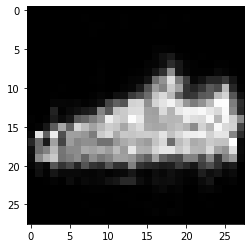

Sneaker


In [0]:
# 만들고 싶은 아이템 생성하고 시각화하기

item_class = 7 # 아이템 번호
z = torch.randn(1, 100).to(device) # 배치 크기 1
g_label = torch.full((1,), item_class, dtype=torch.long).to(device)
sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()
print(label_list[item_class])

In [0]:
# 본인의 구글 드라이브 → 지금 실행중인 코드

# google.colab.drive : 구글 드라이브에서 파일을 가져오기 위한 코드를 담고 있다.
from google.colab import drive

# 본인의 구글 드라이브를 '/gdrive' 라는 경로로 하여 쓸 수 있다.
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# D, G 모델 따로 저장
torch.save(D.state_dict(), '/gdrive/My Drive/cGAN_FashionMNIST_D.pt')
torch.save(G.state_dict(), '/gdrive/My Drive/cGAN_FashionMNIST_G.pt')

# 다시 불러오기 위해 모델 제거
del D, G

# 모델을 불러오기 위한 객체화
D = Discriminator().to(device)
G = Generator().to(device)

# 모델 파라미터 불러오기
D.load_state_dict(torch.load('/gdrive/My Drive/cGAN_FashionMNIST_D.pt'))
G.load_state_dict(torch.load('/gdrive/My Drive/cGAN_FashionMNIST_G.pt'))

<All keys matched successfully>